In [1]:
import numpy as np
import matplotlib.pyplot as plt


from qiskit.circuit import ParameterVector
from qiskit.opflow import X, Z, I, Y


from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator,
                                Sampler as RuntimeSampler,
                                Options)
from qiskit.primitives import Sampler,Estimator
from qiskit import *
from qiskit.visualization import *
from qiskit.algorithms.optimizers import COBYLA,NFT,GradientDescent,ADAM,SPSA
from qiskit.algorithms.minimum_eigensolvers import  VQE
from qiskit.circuit.library import EvolvedOperatorAnsatz

C:\Users\rubenb\AppData\Local\Temp\ipykernel_16708\3280752877.py:6: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X, Z, I, Y
C:\Users\rubenb\AppData\Local\Temp\ipykernel_16708\3280752877.py:9: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import MinimumEigensolver, VQEResult


In [2]:
Id = np.array([[1, 0],
              [0, 1]])
X_pauli = np.array([[0, 1],
              [1, 0]])
Y_pauli = np.array([[0, -1j],
              [1j, 0]])
Z_pauli = np.array([[1, 0],
              [0, -1]])
H = np.array([[1, 1],
              [1, -1]]) / np.sqrt(2)
S = np.array([[1, 0],
              [0, 1j]])

CNOT01 = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 0, 1],
                   [0, 0, 1, 0]])
CNOT10 = np.array([[1, 0, 0, 0],
                   [0, 0, 0, 1],
                   [0, 0, 1, 0],
                   [0, 1, 0, 0]])
SWAP = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1]])

In [3]:
# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class QiskitVQE(MinimumEigensolver):
    
    def __init__(self,estimator, ansatz, optimizer,ham,initial_parameters=None,callback=None):
        self._estimator = estimator
        self._circuit = ansatz
        self._optimizer = optimizer
        self._callback = callback
        self._initial_parameters=initial_parameters
        self._obs=ham

        
    def compute_minimum_eigenvalue(self):
                
        # Define objective function to classically minimize over
        def objective(x):
            job = self._estimator.run(self._circuit,self._obs,[x])
            H=job.result().values[0]
            
            if self._callback is not None:
                self._callback([H,x])
            return H
            
        # Select an initial point for the ansatzs' parameters
        if self._initial_parameters is None:
            x0 = np.pi/2 * np.random.rand(self._circuit.num_parameters)
            
        else:
            x0=self._initial_parameters
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)

        job = self._estimator.run(self._circuit,self._obs,[res.x])
        H=job.result().values[0]

        return H

In [4]:
def two_level_Hamiltonian(E1,E2,V11,V12,V21,V22,l):
    H_0=np.array([[E1, 0],
                  [0, E2]])
    H_1= np.array([[V11, V12],
                   [V21, V22]])
    
    return H_0+l*H_1

In [5]:
H=two_level_Hamiltonian(0,4,3,0.2,0.2,-3,1)
val,vecs=np.linalg.eigh(H)

In [6]:
def ansatz(N_qubits,N_layers):
  theta = ParameterVector("m",2*N_qubits*N_layers)
  qr=QuantumRegister(N_qubits)
  qc=QuantumCircuit(qr)
  k=0
  for _ in range(N_layers):
    for i in range(N_qubits):
        qc.rx(theta[k],qr[i])
        k+=1
        qc.ry(theta[k],qr[i])
        k+=1

  return qc

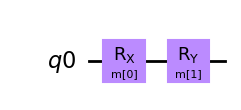

In [7]:
ansatz(1,1).draw(output='mpl')

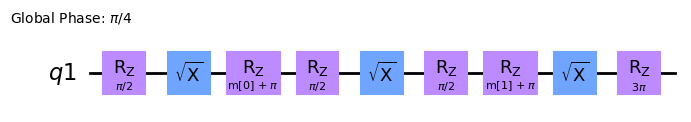

In [8]:
transpile(ansatz(1,1),basis_gates=['cx','rz','sx','x']).draw(output='mpl')

In [9]:
def Hamiltonian_pauli(E1,E2,V11,V12,V21,V22,l):
    E=(E1+E2)/2
    Om=(E1-E2)/2
    c=(V11+V22)/2
    w_z=(V11-V22)/2
    w_x=V12

    
    return E*I + Om*Z + l*c*I + l*w_z*Z + l*w_x*X

In [10]:
ham=Hamiltonian_pauli(0,4,3,0.2,0.2,-3,1)

In [11]:
intermediate_info = []
def callback(data):
                intermediate_info.append(data)

# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator()




cobyla=COBYLA(maxiter=1000, disp=True, rhobeg=0.1, tol=0.01, options=None)
adam=ADAM(maxiter=300, tol=1e-02, lr=0.1, beta_1=0.9, beta_2=0.99, noise_factor=1e-10, eps=1e-10, amsgrad=True, snapshot_dir=None)
g_d=GradientDescent(maxiter=300,learning_rate=0.1, tol=0.001, callback=None, perturbation=None)
spsa=SPSA(maxiter=100, blocking=False, allowed_increase=None, trust_region=False, learning_rate=None, perturbation=None, last_avg=1, resamplings=1, perturbation_dims=None, callback=None)

ans=ansatz(1,1)

custom_vqe = QiskitVQE(estimator,ans,g_d,ham,None,callback=callback)
result = custom_vqe.compute_minimum_eigenvalue()

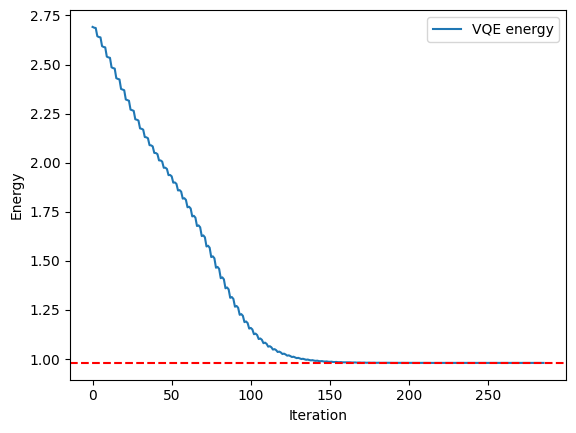

In [12]:
en=[]
param=[]
for info in intermediate_info:
    en.append(info[0])
    param.append(info[1])
plt.plot(en,label='VQE energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.axhline(y=val[0], color='r', linestyle='--',label='E0')


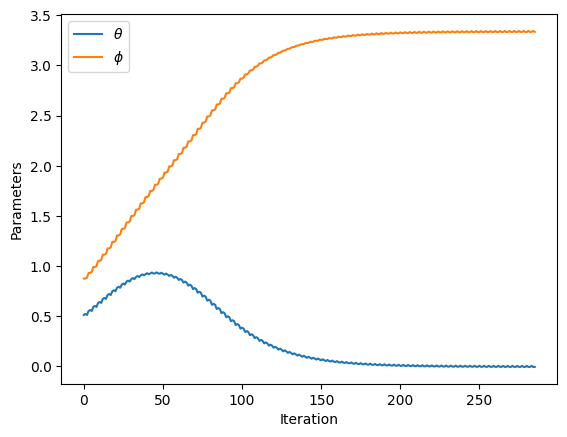

In [13]:
p1=[]
p2=[]
for p in param:
    p1.append(p[0])
    p2.append(p[1])
plt.plot(p1,label=r'$\theta$')
plt.plot(p2,label=r'$\phi$')
plt.xlabel('Iteration')
plt.ylabel('Parameters')
plt.legend()


In [14]:
optimizers=[cobyla,adam,g_d,spsa]
labels=['cobyla','adam','gradient descent','spsa']
infos=[]
for opt in optimizers:
    intermediate_info= []
    initial_parameters=[np.pi/2,np.pi/2]
    H=Hamiltonian_pauli(0,4,3,0.2,0.2,-3,1)
    custom_vqe = QiskitVQE(estimator,ans,opt,H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)

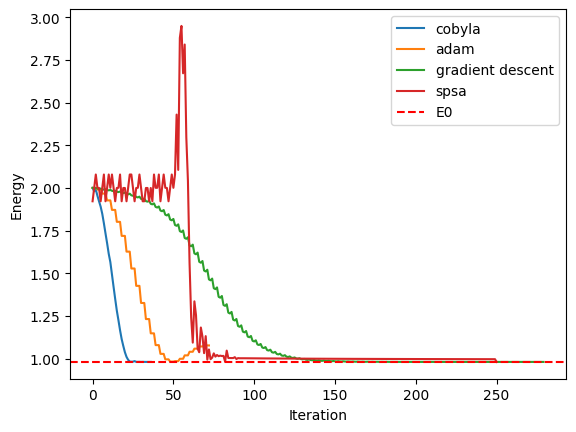

In [15]:
for i,opt_info in enumerate(infos):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.show()

In [16]:
num_shots=[1000,10000,100000,None]
labels=['n=1000','n=10000','n=100000','n=exact']
infos=[]
for shots in num_shots:
    intermediate_info= []
    initial_parameters=[np.pi/2,np.pi/2]
    estimator = Estimator(options={'shots': shots})
    H=Hamiltonian_pauli(0,4,3,0.2,0.2,-3,1)
    custom_vqe = QiskitVQE(estimator,ans,cobyla,H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)

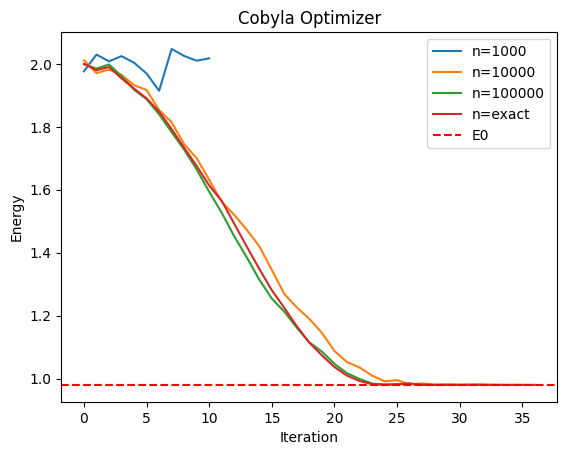

In [17]:
for i,opt_info in enumerate(infos):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.title('Cobyla Optimizer')
plt.show()

In [18]:

infos=[]
for shots in num_shots:
    intermediate_info= []
    initial_parameters=[np.pi/2,np.pi/2]
    estimator = Estimator(options={'shots': shots})
    H=Hamiltonian_pauli(0,4,3,0.2,0.2,-3,1)
    custom_vqe = QiskitVQE(estimator,ans,adam,H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)

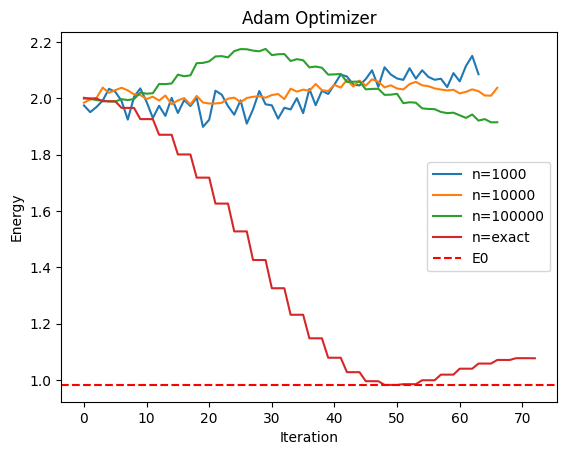

In [19]:
for i,opt_info in enumerate(infos):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.title('Adam Optimizer')
plt.show()

In [20]:

infos=[]
for shots in num_shots:
    intermediate_info= []
    initial_parameters=[np.pi/2,np.pi/2]
    estimator = Estimator(options={'shots': shots})
    H=Hamiltonian_pauli(0,4,3,0.2,0.2,-3,1)
    custom_vqe = QiskitVQE(estimator,ans,g_d,H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)

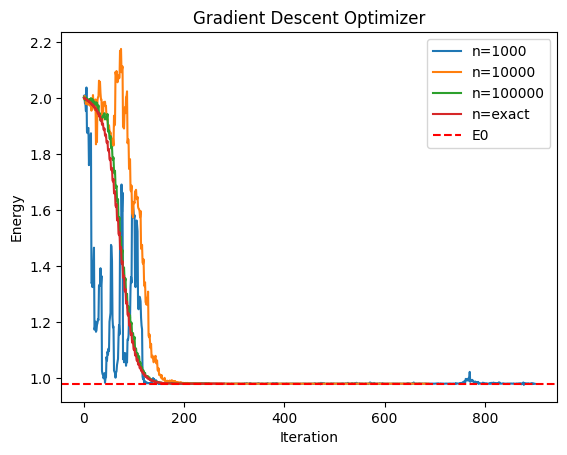

In [21]:
for i,opt_info in enumerate(infos):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val[0], color='r', linestyle='--',label='E0')
#plt.xlim(0,200)
plt.legend()
plt.title('Gradient Descent Optimizer')
plt.show()

In [22]:

infos=[]
for shots in num_shots:
    intermediate_info= []
    initial_parameters=[np.pi/2,np.pi/2]
    estimator = Estimator(options={'shots': shots})
    H=Hamiltonian_pauli(0,4,3,0.2,0.2,-3,1)
    custom_vqe = QiskitVQE(estimator,ans,spsa,H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)

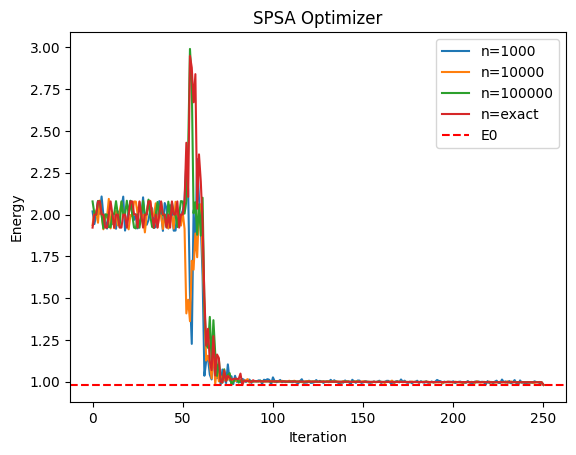

In [23]:
for i,opt_info in enumerate(infos):
    en=[]
    param=[]
    for info in opt_info:
        en.append(info[0])
        param.append(info[1])
    plt.plot(en,label=labels[i])
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
plt.axhline(y=val[0], color='r', linestyle='--',label='E0')
plt.legend()
plt.title('SPSA Optimizer')
plt.show()

In [43]:
gs_shots=[]
gs_None=[]
excited_shots=[]
excited_None=[]
optimizer=spsa
lambdas=np.arange(0.01,4/3,4/30)
ans=ansatz(1,2)

for l in lambdas:
    intermediate_info= []
    initial_parameters=np.ones(ans.num_parameters)*np.pi/2
    
    H=Hamiltonian_pauli(0,4,3,0.2,0.2,-3,l)
    estimator = Estimator(options={'shots': 10000})
    custom_vqe = QiskitVQE(estimator,ans,optimizer,H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_shots.append(result)

    estimator = Estimator(options={'shots': None})
    custom_vqe = QiskitVQE(estimator,ans,optimizer,H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    gs_None.append(result)


    estimator = Estimator(options={'shots': 10000})
    custom_vqe = QiskitVQE(estimator,ans,optimizer,-H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    excited_shots.append(result)

    estimator = Estimator(options={'shots': None})
    custom_vqe = QiskitVQE(estimator,ans,optimizer,-H,initial_parameters=initial_parameters,callback=callback)
    result = custom_vqe.compute_minimum_eigenvalue()
    infos.append(intermediate_info)
    excited_None.append(result)




In [44]:
lambdas_ex=np.arange(0.001,4/3,0.01)
vals_1=[]
vals_2=[]
vecs_1=[]
vecs_2=[]
for l in lambdas_ex:
    H=two_level_Hamiltonian(0,4,3,0.2,0.2,-3,l)
    val,vecs=np.linalg.eigh(H)
    vals_1.append(val[0])
    vals_2.append(val[1])

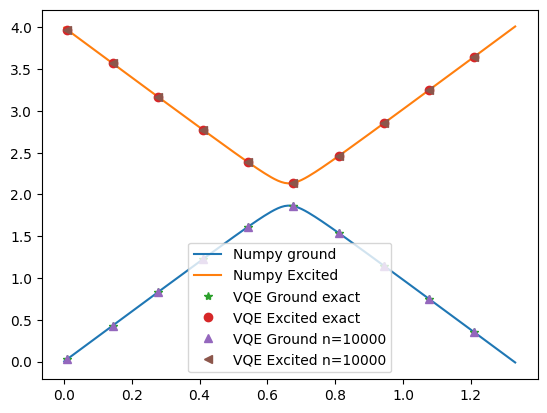

In [45]:
plt.plot(lambdas_ex,vals_1,label='Numpy ground')
plt.plot(lambdas_ex,vals_2,label='Numpy Excited')
plt.plot(lambdas,gs_None,linestyle='',marker='*',label='VQE Ground exact')
plt.plot(lambdas,-np.array(excited_None),linestyle='',marker='o',label='VQE Excited exact')
plt.plot(lambdas,gs_shots,linestyle='',marker='^',label='VQE Ground n=10000')
plt.plot(lambdas,-np.array(excited_shots),linestyle='',marker='<',label='VQE Excited n=10000')
plt.legend()
plt.show()